# Extract data within a shapefile using ERDDAP

This tutorial will teach you how to extract and display SST values for a particular time period or average SST over the whole time-series available within a shapefile.

The shapefile for the NOAA Marine National Monument and sanctuaries boundaries can be downloaded here: 
http://sanctuaries.noaa.gov/library/imast_gis.html. 
We are going to extract SST data for the Papahanaumokuakea Marine National Monument (PMNM) in Hawaii. However, because the Monument boundaries cross the dateline, the shapefile provided on the website is tricky to work with. We'll work with a cleaned up version, available here:
https://oceanwatch.pifsc.noaa.gov/files/PMNM_bounds.csv

## Load packages

In [2]:
import pandas as pd
import numpy as np
import time
import urllib.request 
import xarray as xr 
import netCDF4 as nc
from matplotlib import pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import Point, Polygon
import geopandas as gpd

np.warnings.filterwarnings('ignore')

## Load the Monument boundary

In [3]:
df=pd.read_csv('PMNM_bounds.csv')

Transform the boundary to a Polygon

In [4]:
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
poly = Polygon([(p.x, p.y)  for p in  geometry])

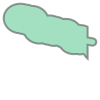

In [5]:
poly

## Data extraction

The example below extracts monthly 5km CoralTemp SST data within the monument boundary. 

- We are going to download data from ERDDAP for the smallest bounding box that contains our polygon

In [6]:
xcoord1 = (np.min(df.lon), np.max(df.lon))
ycoord1 = (np.min(df.lat), np.max(df.lat))

In [33]:
xcoord1


(177.84422, 198.9827)

In [34]:
ycoord1

(19.2345832, 31.79786423)

- let's select a date range:

In [7]:
tcoord = ("2019-01-15", "2019-12-15")

- and let's build our ERDDAP URL:

In [8]:
url='https://oceanwatch.pifsc.noaa.gov/erddap/griddap/CRW_sst_v1_0_monthly.nc?analysed_sst[('+ tcoord[0] +'):1:('+ tcoord[1] +')][('+ str(ycoord1[0]) +'):1:('+ str(ycoord1[1]) +')][(' + str(xcoord1[0]) +'):1:('+ str(xcoord1[1]) +')]'

In [9]:
url

'https://oceanwatch.pifsc.noaa.gov/erddap/griddap/CRW_sst_v1_0_monthly.nc?analysed_sst[(2019-01-15):1:(2019-12-15)][(19.2345832):1:(31.79786423)][(177.84422):1:(198.9827)]'

- now we can download the data:

In [10]:
urllib.request.urlretrieve(url, "sst.nc")

('sst.nc', <http.client.HTTPMessage at 0x7f106a490280>)

- and load it as an xarray dataset:

In [11]:
ds = xr.open_dataset('sst.nc',decode_cf=False)

In [12]:
ds.analysed_sst.shape

(12, 252, 424)

We now have data for a box around our polygon, for 12 monthly time steps (= 1 year).

## Masking the data outside the Monument boundary

The .within() function from the shapelypackage checks if a point is within a polygon. We are using it to create a mask which will take the value 1 within the polygon boundary, and NaN outside.

(This takes about 1min or less to run).

In [13]:
start_time=time.time()
mask=np.empty((len(ds.latitude.values),len(ds.longitude.values)))
mask[:]=np.NaN

for i in range(len(ds.latitude.values)):
    for j in range(len(ds.longitude.values)):
        p=Point(ds.longitude.values[j],ds.latitude.values[i],)     
        if int(p.within(poly))==1:
            mask[i,j]=int(p.within(poly))
            
end_time=time.time()
print("total time = %g mins" % ((end_time-start_time)/60.))

total time = 0.564597 mins


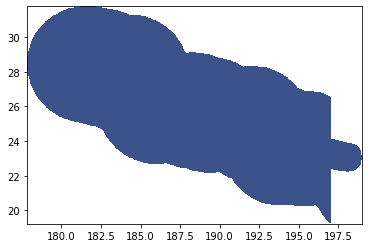

In [14]:
plt.contourf(ds.longitude,ds.latitude,mask)

We now multiply the SST data we downloaded by the mask values:

In [15]:
SST=ds.analysed_sst*mask

## Plotting the data

The extracted data contains several time steps (months) of sst data in the monument boundaries. Let's make a plot of the 4th time step for example.

- setting up the colormap

In [16]:
np.min(SST),np.max(SST)

(<xarray.DataArray 'analysed_sst' ()>
 array(16.86333333),
 <xarray.DataArray 'analysed_sst' ()>
 array(28.78))

In [17]:
levs = np.arange(16, 29, 0.05)
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"] 
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))

- plot:

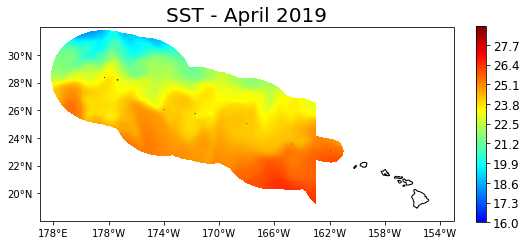

In [44]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 10))

# Label axes of a Plate Carree projection with a central longitude of 180:

ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_extent([177, 207, 18, 32], ccrs.PlateCarree())
ax1.coastlines()
ax1.set_xticks(range(178,207,4), crs=ccrs.PlateCarree())
ax1.set_yticks(range(20,32,2), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

ax1=plt.contourf(ds.longitude,ds.latitude,SST[4,:,:],levs,cmap=cm,transform=ccrs.PlateCarree())
cbar=plt.colorbar(fraction=0.022)
cbar.ax.tick_params(labelsize=12) 
#cs.ax.tick_params(labelsize=12)
plt.title('SST - April 2019', fontsize=20)

plt.show()

## Example of loading and working which an ESRI shapefile instead of .csv file

Let's download a shapefile of the main Hawaiian Islands, from the State of Hawaii website: https://planning.hawaii.gov/gis/download-gis-data-expanded/

Download the coastline shapefile: https://files.hawaii.gov/dbedt/op/gis/data/coast_n83.shp.zip
and save it to your computer, and unzip.

In [22]:
from shapely.geometry import Point, Polygon

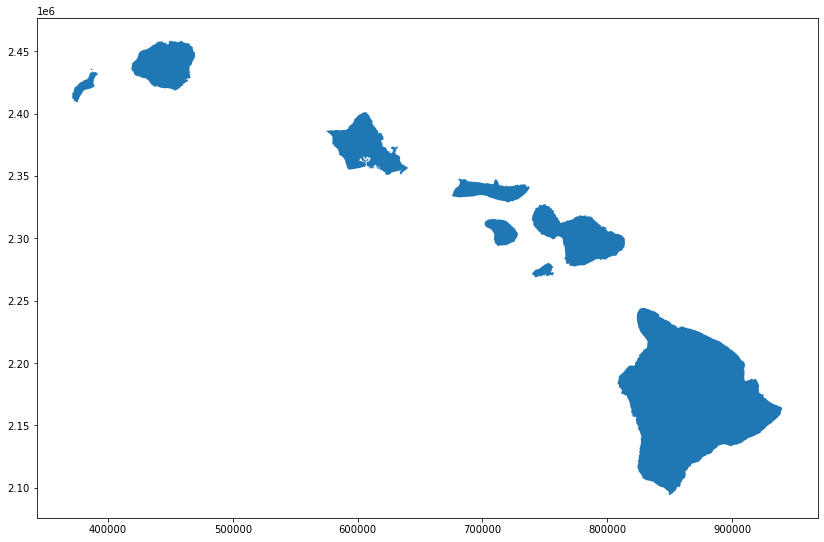

In [26]:
import geopandas as gpd
from matplotlib import pyplot as plt 
fp='coast_n83.shp/coast_n83.shp'
data = gpd.read_file(fp)

data.plot(figsize=(14, 10))
plt.show()

In [27]:
data

,AREA,PERIMETER,COASTLINE_,COASTLIN_1,WATER,geometry
0,1.436729e+09,201403.677,2,6,0,"POLYGON ((460110.193 2457446.021, 460127.255 2..."
1,1.099133e+06,6195.871,3,14,0,"POLYGON ((386773.512 2434856.011, 386762.074 2..."
2,1.863355e+08,83549.716,4,15,0,"POLYGON ((390419.743 2432820.417, 390426.993 2..."
3,1.546408e+09,381624.267,5,17,0,"POLYGON ((603081.220 2399886.893, 603149.469 2..."
4,1.844934e+06,7897.713,6,18,0,"POLYGON ((607748.827 2363405.920, 607730.327 2..."
5,8.768437e+05,4463.074,7,19,1,"POLYGON ((609318.894 2357506.733, 609343.269 2..."
6,2.072612e+06,7228.803,8,20,0,"POLYGON ((616130.011 2357149.079, 616123.136 2..."
7,6.752768e+08,191967.661,9,12,0,"POLYGON ((687118.835 2346925.744, 687142.210 2..."
8,1.887675e+09,309213.835,10,10,0,"POLYGON ((746643.293 2326473.297, 746688.044 2..."
9,3.654021e+08,93216.920,11,8,0,"POLYGON ((709229.796 2315624.344, 709236.171 2..."


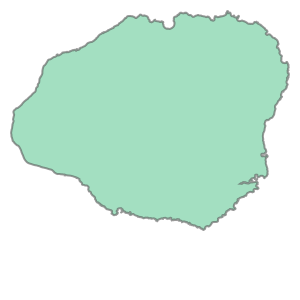

In [28]:
data.geometry[0]